<a href="https://colab.research.google.com/github/thomaskopalidis/DeepLearningproject/blob/main/Alzheimer_MRI_pytorch_and_sklearn_ML_(8_different_models).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color: #FF1493;">Alzheimer MRI Disease Classifications</span></span>


This notebook is to see the comparison between the ML model and deep learning model (CNN). I use both pytorch and sklearn.  

The aim of this task is to classify if a patient, and if so to what degree, has Alzheimers disease using an MRI scan of the patient brain. In total we are predicting one of four classes those being:

*   Non demented
*   Very midly demented
*   Mildly demented
*   Moderately demented








#Installing Required Libraries

In [32]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
cudnn.benchmark = True


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


#Reading and Understanding the data

In [33]:
df =pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet", engine='pyarrow')
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


We see that these data are in a peculiar format. It is simply a dictionary which somehow is an image and then the label. The first thing we want to do is convert these cryptic "images" into a numpy array representing the intensity of the pixels (we assume the MRI are grayscale).

In [34]:
test = pd.read_parquet("test-00000-of-00001-44110b9df98c5585.parquet", engine='pyarrow')

In [35]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

This function is designed to take a dictionary containing image data in the form of bytes and convert it into an image (NumPy array), specifically in grayscale. If the input format isn't as expected, an error is raised.

In [36]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [37]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis = 1, inplace=True)

#Exploring Data

In [8]:
# 1. Check the shape of the DataFrame
print(f"Dataset Shape: {df.shape}")
print("-------------------")
# 2. Display first 5 rows
print(df.head())
print("-------------------")
# 3. Show column names
print(f"Columns: {df.columns}")
print("-------------------")
# 4. Show data types of each column
print(f"Data Types: \n{df.dtypes}")
print("-------------------")
# 5. Check for missing values
print(f"Missing Values: \n{df.isnull().sum()}")

print("-------------------")
# 6. Display summary statistics for numeric columns
print(f"Summary Statistics: \n{df.describe()}")
print("-------------------")
# 7. Show basic info about the dataset
df.info()

# 8. Check for duplicate rows
#print(f"Duplicate Rows: {df.duplicated().sum()}")

# 9. Explore unique values in a column (example: 'category')
#print(f"Unique Values in 'category' column: {df['category'].unique()}")

# 10. Visualize histograms for all numeric columns
#df.hist(figsize=(10, 8))


Dataset Shape: (5120, 2)
-------------------
   label                                            img_arr
0      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1      0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
-------------------
Columns: Index(['label', 'img_arr'], dtype='object')
-------------------
Data Types: 
label       int64
img_arr    object
dtype: object
-------------------
Missing Values: 
label      0
img_arr    0
dtype: int64
-------------------
Summary Statistics: 
             label
count  5120.000000
mean      2.055469
std       0.959244
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       3.000000
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column   Non-Null Co

So, we creates a 2x3 grid of subplots, each displaying a random image from the df DataFrame in grayscale, along with the corresponding disease label as the title. The images are drawn from the img_arr column, and the labels are obtained from the label column. The disease_label_from_category dictionary is used to convert the numeric or categorical labels into human-readable disease names. Finally, the layout is adjusted and the plot is shown.

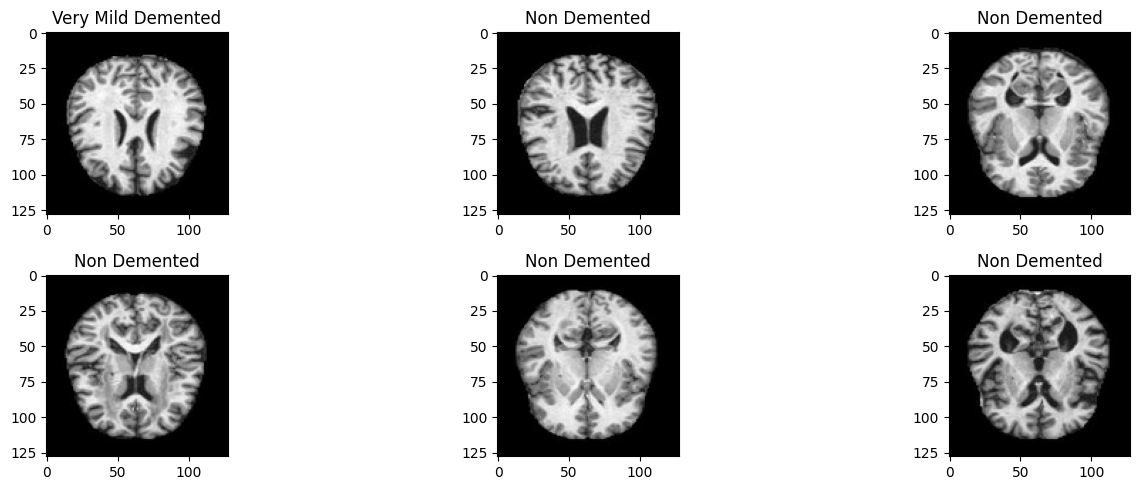

In [9]:
#create subplots
#This creates a figure (fig) and a grid of subplots (ax) with 2 rows and 3 columns,
#so you will have 6 subplots in total.
#The figsize=(15,5) argument specifies the size of the entire figure in inches (width=15, height=5).
#Flattening the Axes Array
#The ax array, which is a 2x3 grid of subplots, is flattened into a 1D array (axs),
# so that each subplot can be accessed in a loop by iterating over the axs array.
fig, ax = plt.subplots(2, 3, figsize=(15,5))
axs = ax.flatten()
for axes in axs:
    #select a random image
    rand = np.random.randint(0, len(df))
    #display the image
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    # Setting the Title for Each Plot
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

Find how many of the images are categorized in each class  

In [10]:
class_counts = df['label'].value_counts()
print(class_counts)

label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


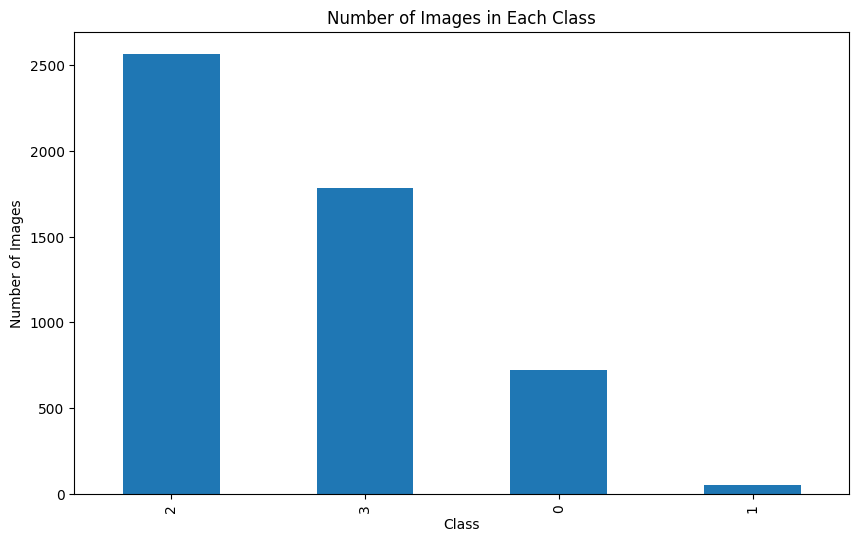

Total samples in training Data = 5120


In [11]:
class_counts.plot(kind='bar', figsize=(10,6))
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()
print(f"Total samples in training Data = {len(df)}")

Instead of labels = [0,1,2,3] use disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [12]:
 # Map the numeric labels to category names using the dictionary
df['category_name'] = df['label'].map(disease_label_from_category)

# Count the number of images in each category
category_counts = df['category_name'].value_counts()

print(category_counts)

category_name
Non Demented          2566
Very Mild Demented    1781
Mild Demented          724
Moderate Demented       49
Name: count, dtype: int64


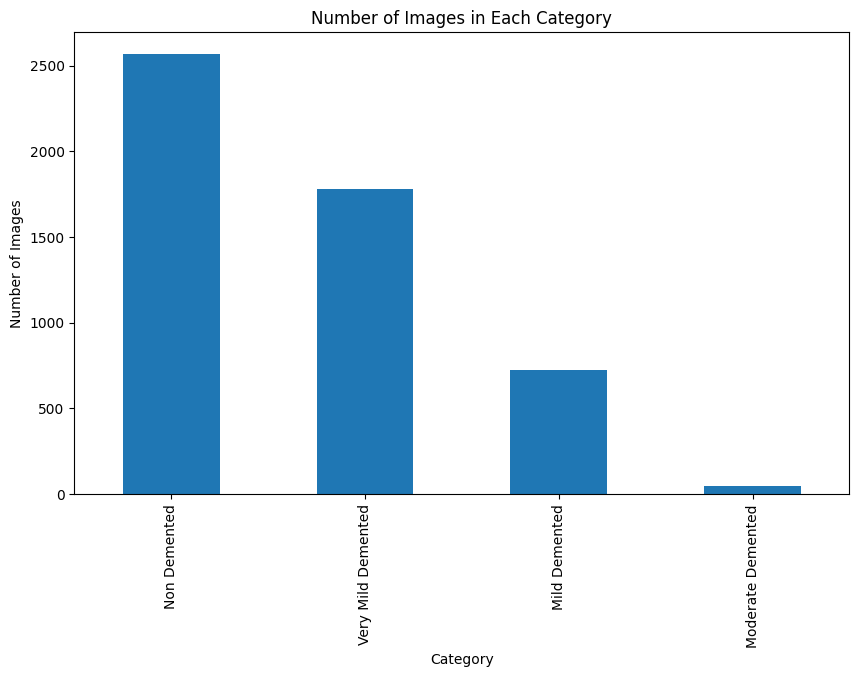

In [13]:
category_counts.plot(kind='bar', figsize=(10,6))
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

We can see that we have an imbalanced data with a few images for moderate Demented. We also observe we have ~5000 images in the dataset. This is actually a fair amount on its own but we can enhance our statistics by using augmentation! This will probably prove to be very useful for the mildly and moderately demented patient MRIs, of which we have far fewer scans.

In [14]:
N_CLASSES = df['label'].nunique()
print(N_CLASSES)

4



Baseline: No augmentation with a basic CNN

We use the PyTorch Dataset and DataLoader objects to handle our data and feeding it into the model. You can see if the dataset all we have to do is implement the three methods given. The __getitem__ is the most important!


In [15]:
# Use a torch dataset/dataloader to handle feeding our data in the model
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [16]:
class BaselineCNN(nn.Module):
    # Basic CNN using 2D convolutional layers, some max pooling and
    # a single batch normalisation layer to counter overfitting. We used a linear (dense)
    # layer as the output with the output shape being the number of classes
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.out = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [17]:
#Hyperparameters
learning_rate = 0.001
NEPOCHS = 10
batch_size = 32

In [18]:
#Create dataset and dataloader
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [19]:
def train_model(model, loader, optimizer, num_epochs=NEPOCHS):
    # Initialize model, loss function, and optimizer
    criterion = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    for epoch in tqdm.tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

    print('Finished Training')
    return model, train_losses

In [20]:
model = BaselineCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model, train_losses = train_model(model, train_loader, optimizer)

100%|██████████| 10/10 [39:28<00:00, 236.87s/it]

Finished Training


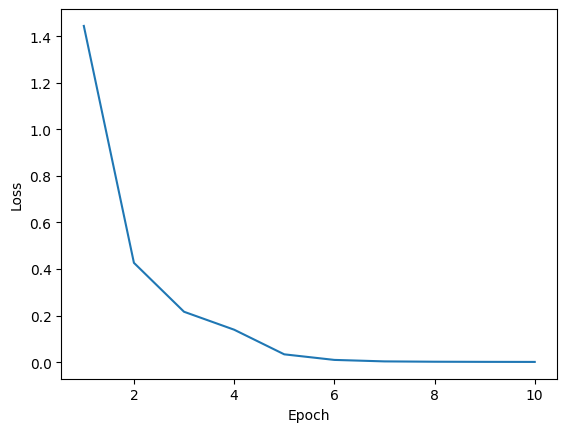

In [21]:
plt.plot(np.arange(1, 11), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [22]:
def predict(m, dl, device):
    m.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in dl:
            images = images.to(device)
            outputs = m(images)
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

def result_summary(predictions, true_labels):
    # Accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Precision, Recall, F1 Score
    #class_report = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    #print('Classification Report:')
    #print(class_report)

In [23]:
# Lets display some basic summary statistics to see how we did
# Note: this is dreadful practice to evaluate on the training data but this won't be our
# final model and is just for demonstration purposes!
predictions, true_labels = predict(model, train_loader, device)
result_summary(predictions, true_labels)

Accuracy: 1.0000
Confusion Matrix:
[[ 724    0    0    0]
 [   0   49    0    0]
 [   0    0 2566    0]
 [   0    0    0 1781]]


#Test the test data

In [24]:
# Run the same report on the test data
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)

result_summary(predictions_test, test_labels)

Accuracy: 0.9711
Confusion Matrix:
[[161   0   5   6]
 [  0  14   0   1]
 [  1   0 628   5]
 [  0   0  19 440]]


train --> 100%

test --> 98%



Next i will compare the 8 different ML models to see the difference from the CNN

#Modeling
#Compare 8 different ML models
Logistic Regression

KNN
Random Forest

Support Vector Machine (SVM)

AdaBoost

Naive Bayes

Gradient Boosting

MLP

XGBoost

Training Logistic Regression...
Logistic Regression Accuracy: 92.48%

Logistic Regression Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.90      0.91      0.91       136
 Moderate Demented       1.00      1.00      1.00         5
      Non Demented       0.95      0.93      0.94       533
Very Mild Demented       0.90      0.92      0.91       350

          accuracy                           0.92      1024
         macro avg       0.94      0.94      0.94      1024
      weighted avg       0.93      0.92      0.92      1024



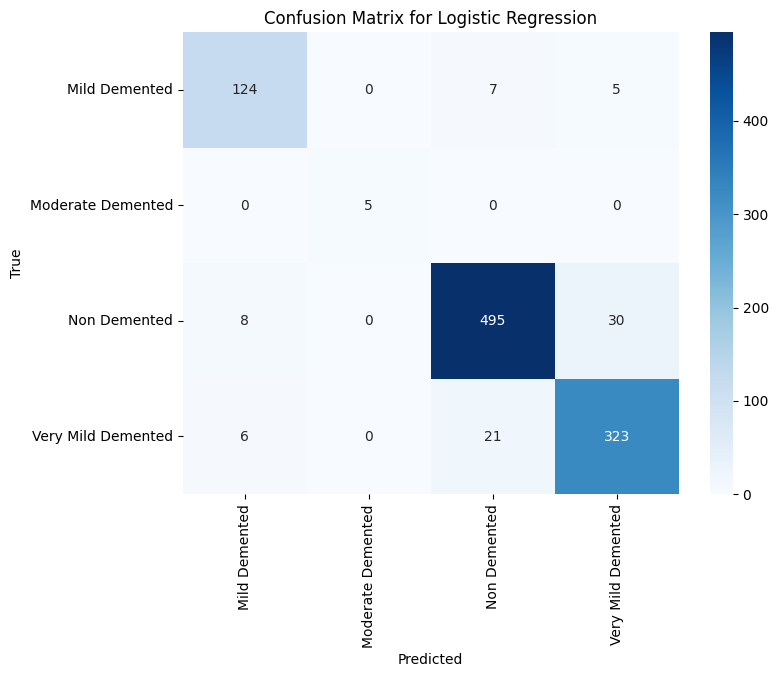

Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 95.21%

K-Nearest Neighbors Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.93      0.95      0.94       136
 Moderate Demented       1.00      1.00      1.00         5
      Non Demented       0.94      0.98      0.96       533
Very Mild Demented       0.97      0.91      0.94       350

          accuracy                           0.95      1024
         macro avg       0.96      0.96      0.96      1024
      weighted avg       0.95      0.95      0.95      1024



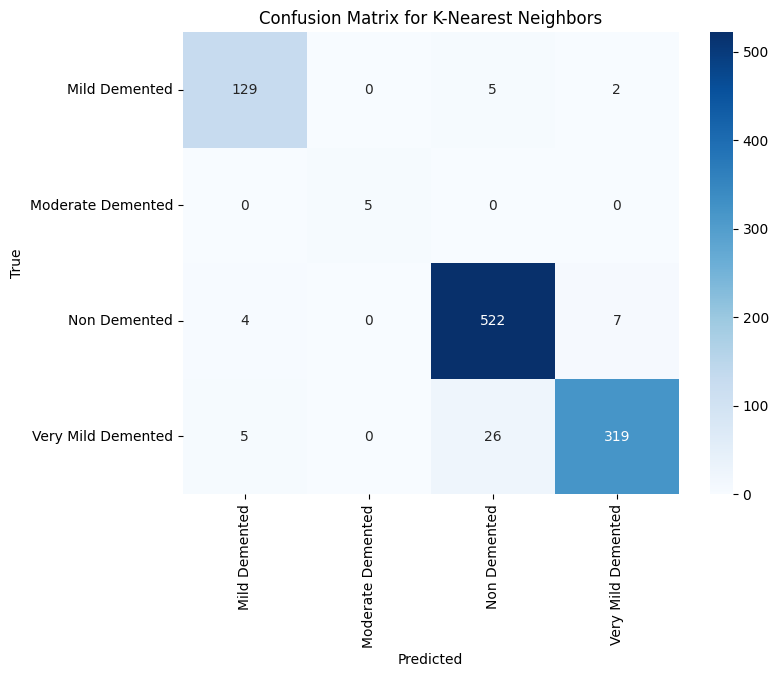

Training Random Forest...
Random Forest Accuracy: 87.60%

Random Forest Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.69      0.82       136
 Moderate Demented       1.00      0.20      0.33         5
      Non Demented       0.87      0.97      0.91       533
Very Mild Demented       0.86      0.82      0.84       350

          accuracy                           0.88      1024
         macro avg       0.93      0.67      0.73      1024
      weighted avg       0.88      0.88      0.87      1024



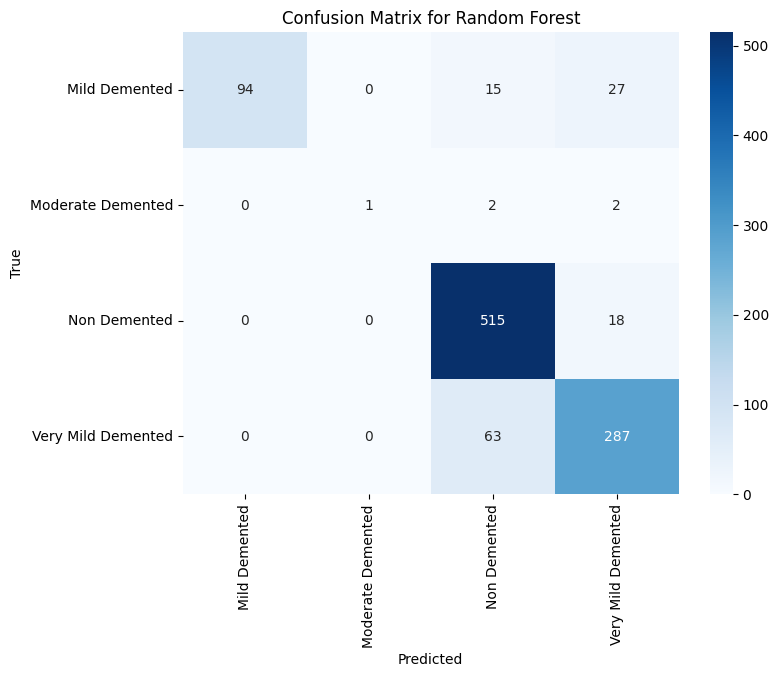

Training Support Vector Machine (SVM)...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Support Vector Machine (SVM) Accuracy: 71.78%

Support Vector Machine (SVM) Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.20      0.33       136
 Moderate Demented       0.00      0.00      0.00         5
      Non Demented       0.76      0.87      0.82       533
Very Mild Demented       0.62      0.69      0.66       350

          accuracy                           0.72      1024
         macro avg       0.60      0.44      0.45      1024
      weighted avg       0.74      0.72      0.69      1024



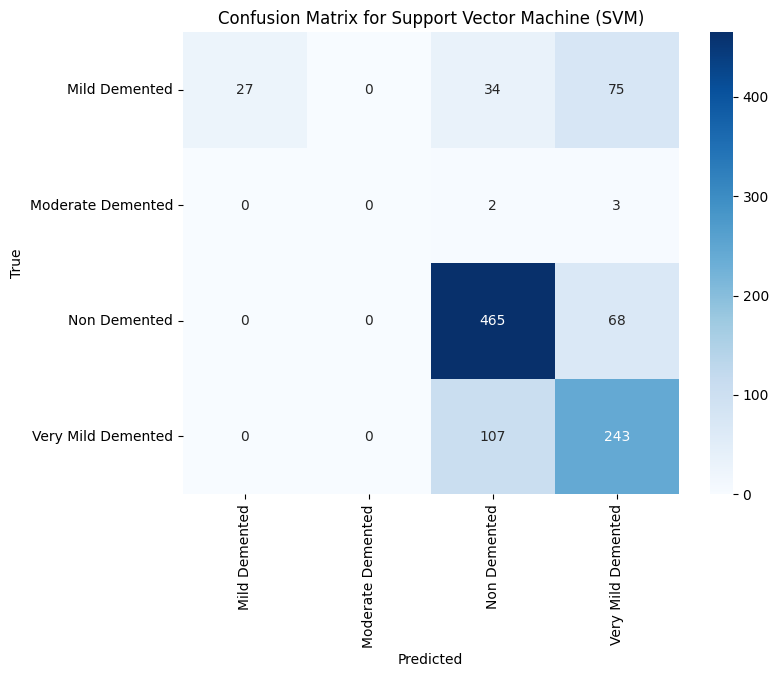

Training AdaBoost...
AdaBoost Accuracy: 55.18%

AdaBoost Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.35      0.28      0.31       136
 Moderate Demented       1.00      0.20      0.33         5
      Non Demented       0.67      0.68      0.68       533
Very Mild Demented       0.44      0.46      0.45       350

          accuracy                           0.55      1024
         macro avg       0.61      0.41      0.44      1024
      weighted avg       0.55      0.55      0.55      1024



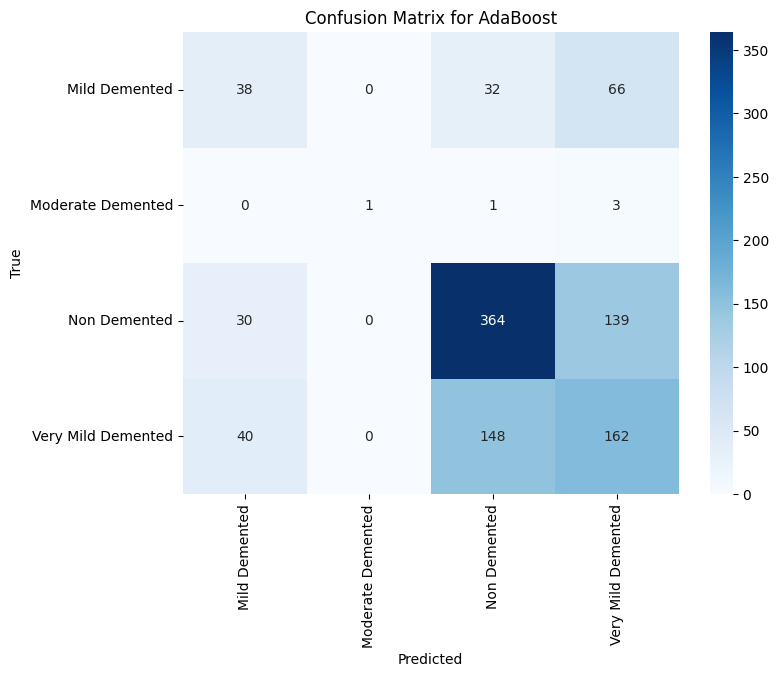

Training Naive Bayes...
Naive Bayes Accuracy: 52.15%

Naive Bayes Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.33      0.53      0.41       136
 Moderate Demented       0.08      1.00      0.15         5
      Non Demented       0.69      0.66      0.68       533
Very Mild Demented       0.44      0.29      0.35       350

          accuracy                           0.52      1024
         macro avg       0.39      0.62      0.40      1024
      weighted avg       0.55      0.52      0.53      1024



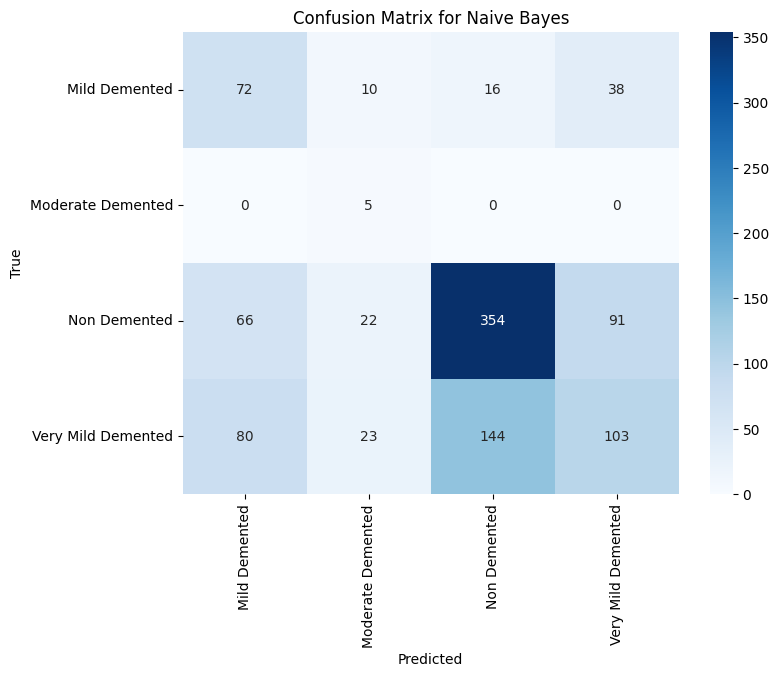

Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

MLP Accuracy: 52.05%

MLP Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       136
 Moderate Demented       0.00      0.00      0.00         5
      Non Demented       0.52      1.00      0.68       533
Very Mild Demented       0.00      0.00      0.00       350

          accuracy                           0.52      1024
         macro avg       0.13      0.25      0.17      1024
      weighted avg       0.27      0.52      0.36      1024



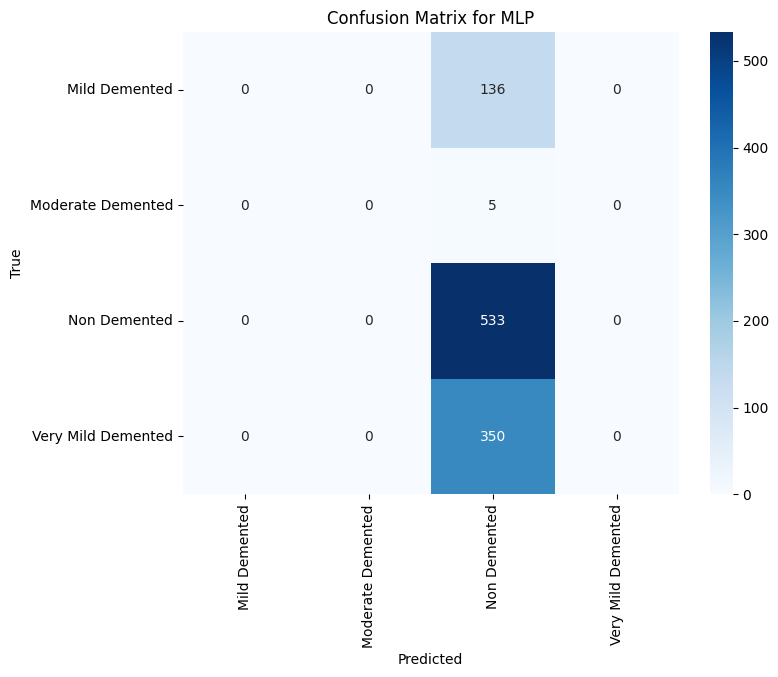

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 95.51%

XGBoost Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       1.00      0.88      0.94       136
 Moderate Demented       1.00      0.60      0.75         5
      Non Demented       0.94      0.99      0.97       533
Very Mild Demented       0.96      0.93      0.95       350

          accuracy                           0.96      1024
         macro avg       0.98      0.85      0.90      1024
      weighted avg       0.96      0.96      0.95      1024



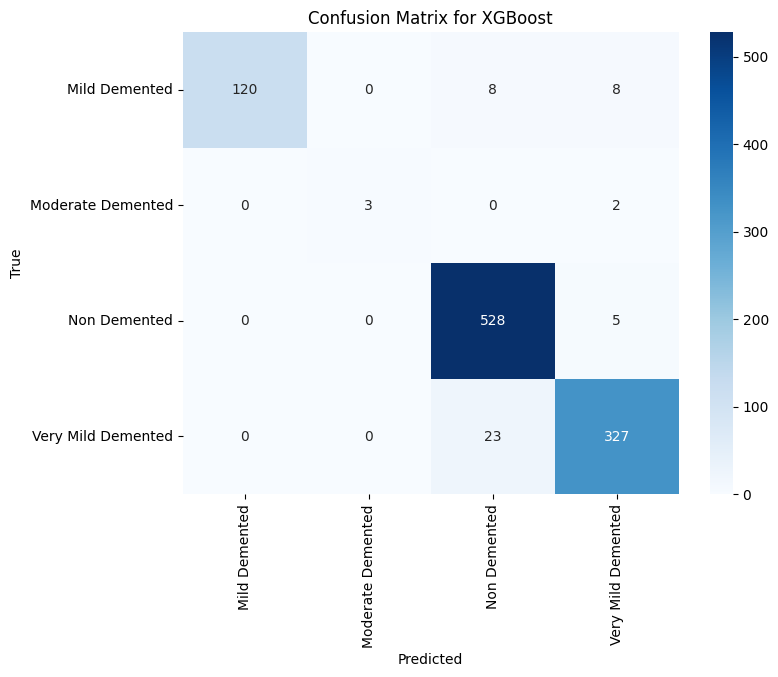


Model Accuracy Comparison:
                          Model   Accuracy  Precision     Recall   F1 Score  \
0           Logistic Regression  92.480469  92.524380  92.480469  92.493425   
1           K-Nearest Neighbors  95.214844  95.278119  95.214844  95.194938   
2                 Random Forest  87.597656  88.191859  87.597656  87.230332   
3  Support Vector Machine (SVM)  71.777344  74.441146  71.777344  69.303304   
4                      AdaBoost  55.175781  54.890666  55.175781  54.831580   
5                   Naive Bayes  52.148438  55.449964  52.148438  52.773291   
6                           MLP  52.050781  27.092838  52.050781  35.636566   
7                       XGBoost  95.507812  95.614354  95.507812  95.454972   

   Time to Run (s)  
0       126.906188  
1         5.279161  
2        31.252191  
3       415.188849  
4       414.761883  
5         1.626440  
6       656.533124  
7       964.092333  


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import pandas as pd

# Assuming df is your dataframe with the preprocessed images as 'img_arr' and 'category_name' labels
# Convert the images into a flat vector
X = np.array([img.flatten() for img in df['img_arr']])

# Encode labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category_name'])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine (SVM)': SVC(random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),  # MLP Model
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)  # XGBoost
}

# Loop over models, train them, and evaluate
results = {}
# Initialize a list to store the results
results_list = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Track time taken for training
    start_time = time.time()
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy,precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Same here, adjust if you want per-class metrics instead


    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")

    # Record the time taken to train and evaluate
    time_taken = time.time() - start_time

    # Append the results to the list
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1 Score': f1 * 100,
        'Time to Run (s)': time_taken
    })

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Show results summary
print("\nModel Accuracy Comparison:")
print(results_df)

# Optionally, save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
